# Bank Note Classification 

http://archive.ics.uci.edu/ml/datasets/banknote+authentication

Data Set Information:

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.


Attribute Information:

1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 
5. class (integer) 


In [1]:
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report


In [22]:
# read .csv from provided dataset
csv_filename="data_banknote_authentication.txt"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename,names=["Variance","Skewness","Curtosis","Entropy","Class"])

In [30]:
df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [29]:
len(df[df['Class'] == 0])

762

In [28]:
len(df[df['Class'] == 1])

610

In [31]:
features=list(df.columns[:-1])
features

['Variance', 'Skewness', 'Curtosis', 'Entropy']

In [32]:
# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(df[features], df['Class'], test_size=0.4, random_state=0)

In [33]:
print X_train.shape, y_train.shape

(823, 4) (823L,)


### Feature importances with forests of trees

This examples shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the feature importances of the forest, along with their inter-trees variability.

In [35]:
X = df[features]
y= df['Class']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X = df[features]
y = df['shares']
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d - %s (%f) " % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [102]:
importances[indices[:5]]

array([ 0.03030539,  0.02698445,  0.0269827 ,  0.02358878,  0.02318772])

In [88]:
for f in range(5):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], features[indices[f]] ,importances[indices[f]]))

1. feature 39 LDA_02 (0.030305)
2. feature 25 kw_avg_avg (0.026984)
3. feature 23 kw_min_avg (0.026983)
4. feature 38 LDA_01 (0.023589)
5. feature 37 LDA_00 (0.023188)


In [141]:
best_features = []
for i in indices[:5]:
    best_features.append(features[i])

In [ ]:
# Plot the top 5 feature importances of the forest
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(5), importances[indices][:5], 
       color="r",  yerr=std[indices][:5], align="center")
plt.xticks(range(5), best_features)
plt.xlim([-1, 5])
plt.show()

# Decision Tree accuracy and time elapsed caculation

In [36]:
t0=time()
print "DecisionTree"

dt = DecisionTreeClassifier(min_samples_split=20,random_state=99)
# dt = DecisionTreeClassifier(min_samples_split=20,max_depth=5,random_state=99)

clf_dt=dt.fit(X_train,y_train)

print "Acurracy: ", clf_dt.score(X_test,y_test)
t1=time()
print "time elapsed: ", t1-t0

DecisionTree
Acurracy:  0.979963570128
time elapsed:  0.0590000152588


## cross validation for DT

In [38]:
tt0=time()
print "cross result========"
scores = cross_validation.cross_val_score(dt, df[features], df['Class'], cv=5)
print scores
print scores.mean()
tt1=time()
print "time elapsed: ", tt1-tt0
print "\n"

cross result========
[ 0.98909091  0.95636364  0.98175182  0.98540146  0.98540146]
0.979601857996
time elapsed:  0.121000051498




### Tuning our hyperparameters using GridSearch

In [39]:
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(criterion='entropy'))
])

parameters = {
    'clf__max_depth': (5, 25 , 50),
    'clf__min_samples_split': (1, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)

print classification_report(y_test, predictions)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   17.1s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best score: 0.972
Best parameters set:
	clf__max_depth: 25
	clf__min_samples_leaf: 1
	clf__min_samples_split: 5
             precision    recall  f1-score   support

          0       0.99      0.98      0.99       306
          1       0.98      0.99      0.98       243

avg / total       0.99      0.99      0.99       549



# Random Forest accuracy and time elapsed caculation

In [40]:
t2=time()
print "RandomForest"
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
clf_rf = rf.fit(X_train,y_train)
print "Acurracy: ", clf_rf.score(X_test,y_test)
t3=time()
print "time elapsed: ", t3-t2

RandomForest
Acurracy:  0.989071038251
time elapsed:  0.72100019455


## cross validation for RF

In [42]:
tt2=time()
print "cross result========"
scores = cross_validation.cross_val_score(rf, df[features], df['Class'], cv=5)
print scores
print scores.mean()
tt3=time()
print "time elapsed: ", tt3-tt2
print "\n"


cross result========
[ 0.99272727  0.99636364  0.99635036  0.99635036  0.99635036]
0.995628400796
time elapsed:  4.11999988556




### Receiver Operating Characteristic (ROC) curve

In [43]:
roc_auc_score(y_test,rf.predict(X_test))

0.98977245219075283

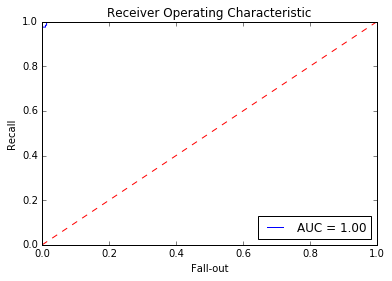

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = rf.predict_proba(X_test)

false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

### Tuning Models using GridSearch

In [54]:

pipeline2 = Pipeline([
('clf', RandomForestClassifier(criterion='entropy'))
])

parameters = {
    'clf__n_estimators': (5, 25, 50, 100),
    'clf__max_depth': (5, 25 , 50),
    'clf__min_samples_split': (1, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3)
}

grid_search = GridSearchCV(pipeline2, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=3)

grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)
print 'Accuracy:', accuracy_score(y_test, predictions)
print classification_report(y_test, predictions)
    

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   51.0s finished


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best score: 0.988
Best parameters set:
	clf__max_depth: 25
	clf__min_samples_leaf: 2
	clf__min_samples_split: 10
	clf__n_estimators: 50
Accuracy: 0.985428051002
             precision    recall  f1-score   support

          0       0.99      0.98      0.99       306
          1       0.98      0.99      0.98       243

avg / total       0.99      0.99      0.99       549



# Naive Bayes accuracy and time elapsed caculation


In [45]:
t4=time()
print "NaiveBayes"
nb = BernoulliNB()
clf_nb=nb.fit(X_train,y_train)
print "Acurracy: ", clf_nb.score(X_test,y_test)
t5=time()
print "time elapsed: ", t5-t4

NaiveBayes
Acurracy:  0.841530054645
time elapsed:  0.102999925613


## cross-validation for NB

In [47]:
tt4=time()
print "cross result========"
scores = cross_validation.cross_val_score(rf, df[features], df['Class'], cv=5)
print scores
print scores.mean()
tt5=time()
print "time elapsed: ", tt5-tt4
print "\n"

cross result========
[ 0.99272727  0.99272727  0.98175182  0.99635036  0.99635036]
0.99198142004
time elapsed:  4.09599995613




# KNN accuracy and time elapsed caculation

In [48]:
t6=time()
print "KNN"
# knn = KNeighborsClassifier(n_neighbors=3)
knn = KNeighborsClassifier()
clf_knn=knn.fit(X_train, y_train)
print "Acurracy: ", clf_knn.score(X_test,y_test) 
t7=time()
print "time elapsed: ", t7-t6

KNN
Acurracy:  0.998178506375
time elapsed:  0.0409998893738


## cross validation for KNN

In [50]:
tt6=time()
print "cross result========"
scores = cross_validation.cross_val_score(rf, df[features], df['Class'], cv=5)
print scores
print scores.mean()
tt7=time()
print "time elapsed: ", tt7-tt6
print "\n"

cross result========
[ 0.99272727  0.99636364  0.98540146  0.99635036  0.99635036]
0.993438619774
time elapsed:  4.117000103




# SVM accuracy and time elapsed caculation

In [51]:
t7=time()
print "SVM"

svc = SVC()
clf_svc=svc.fit(X_train, y_train)
print "Acurracy: ", clf_svc.score(X_test,y_test) 
t8=time()
print "time elapsed: ", t8-t7

SVM
Acurracy:  1.0
time elapsed:  0.0639998912811


## cross validation for SVM

In [53]:
tt7=time()
print "cross result========"
scores = cross_validation.cross_val_score(rf, df[features], df['Class'], cv=5)
print scores
print scores.mean()
tt8=time()
print "time elapsed: ", tt7-tt6
print "\n"

cross result========
[ 0.99272727  0.99636364  0.98905109  0.99635036  0.99635036]
0.994168546782
time elapsed:  27.5080001354




In [55]:
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import grid_search

svc = SVC()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

grid = grid_search.GridSearchCV(svc, parameters, n_jobs=-1, verbose=1, scoring='accuracy')


grid.fit(X_train, y_train)

print 'Best score: %0.3f' % grid.best_score_

print 'Best parameters set:'
best_parameters = grid.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid.predict(X_test)
print classification_report(y_test, predictions)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 1.000
Best parameters set:
	C: 1
	kernel: 'rbf'
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       306
          1       1.00      1.00      1.00       243

avg / total       1.00      1.00      1.00       549



[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   21.5s finished


In [56]:
pipeline = Pipeline([
    ('clf', SVC(kernel='rbf', gamma=0.01, C=100))
])

parameters = {
    'clf__gamma': (0.01, 0.03, 0.1, 0.3, 1),
    'clf__C': (0.1, 0.3, 1, 3, 10, 30),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid_search.predict(X_test)
print classification_report(y_test, predictions)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best score: 1.000
Best parameters set:
	clf__C: 0.3
	clf__gamma: 0.3
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       306
          1       1.00      1.00      1.00       243

avg / total       1.00      1.00      1.00       549



# Multilevel Perceptron accuracy and time elapsed caculation

In [ ]:
from sklearn.neural_network import MultilayerPerceptronClassifier
clf = MultilayerPerceptronClassifier(n_hidden=[2],
                                     activation='logistic',
                                     algorithm='sgd',
                                     random_state=3)
clf.fit(X_train, y_train)

print 'Number of layers: %s. Number of outputs: %s' % (clf.n_layers_, clf.n_outputs_)
predictions = clf.predict(X_test)
print 'Accuracy:', clf.score(X_test, y_test)
for i, p in enumerate(predictions[:10]):
    print 'True: %s, Predicted: %s' % (y_test[i], p)

In [ ]:
pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('mlp', MultilayerPerceptronClassifier(
                n_hidden=[150,100], alpha=0.1))
    ])
print cross_val_score(pipeline, X, y, n_jobs=-1)